In [1]:
from torchvision import datasets, transforms
import torch
def calculate_mean_std(dataset):
    """calculate mean and standard deviation of a dataset"""
    mean = 0.0
    std = 0.0
    total_images = len(dataset)

    for img, _ in dataset:
        mean += img.mean()
        std += img.std()

    mean /= total_images
    std /= total_images

    return mean.item(), std.item()

# normalization transform
transform = transforms.Compose([transforms.ToTensor()])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

mean, std = calculate_mean_std(trainset)
print(f'Before normalization: mean: {mean}, std: {std}')

# normalization transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

mean, std = calculate_mean_std(trainset)
print(f'After normalization: mean: {mean}, std: {std}')

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Before normalization: mean: 0.28604063391685486, std: 0.3204546272754669
After normalization: mean: -7.240076627113012e-08, std: 0.9999945759773254
Using device: cuda


[epoch 1] train loss: 0.4519, test loss: 0.3365, accuracy: 87.95%, precision: 20.31%, recall: 19.65%, f1_score: 19.97%
Validation loss decreased (inf --> 0.336451).  Saving model ...
[epoch 2] train loss: 0.3019, test loss: 0.3209, accuracy: 88.94%, precision: 19.92%, recall: 19.87%, f1_score: 19.89%
Validation loss decreased (0.336451 --> 0.320897).  Saving model ...
[epoch 3] train loss: 0.2756, test loss: 0.3088, accuracy: 88.63%, precision: 20.19%, recall: 19.80%, f1_score: 19.99%
Validation loss decreased (0.320897 --> 0.308809).  Saving model ...
[epoch 4] train loss: 0.2627, test loss: 0.3249, accuracy: 88.18%, precision: 18.59%, recall: 19.69%, f1_score: 19.12%
EarlyStopping counter: 1 out of 5
[epoch 5] train loss: 0.2545, test loss: 0.2980, accuracy: 88.79%, precision: 19.32%, recall: 19.84%, f1_score: 19.57%
Validation loss decreased (0.308809 --> 0.298039).  Saving model ...


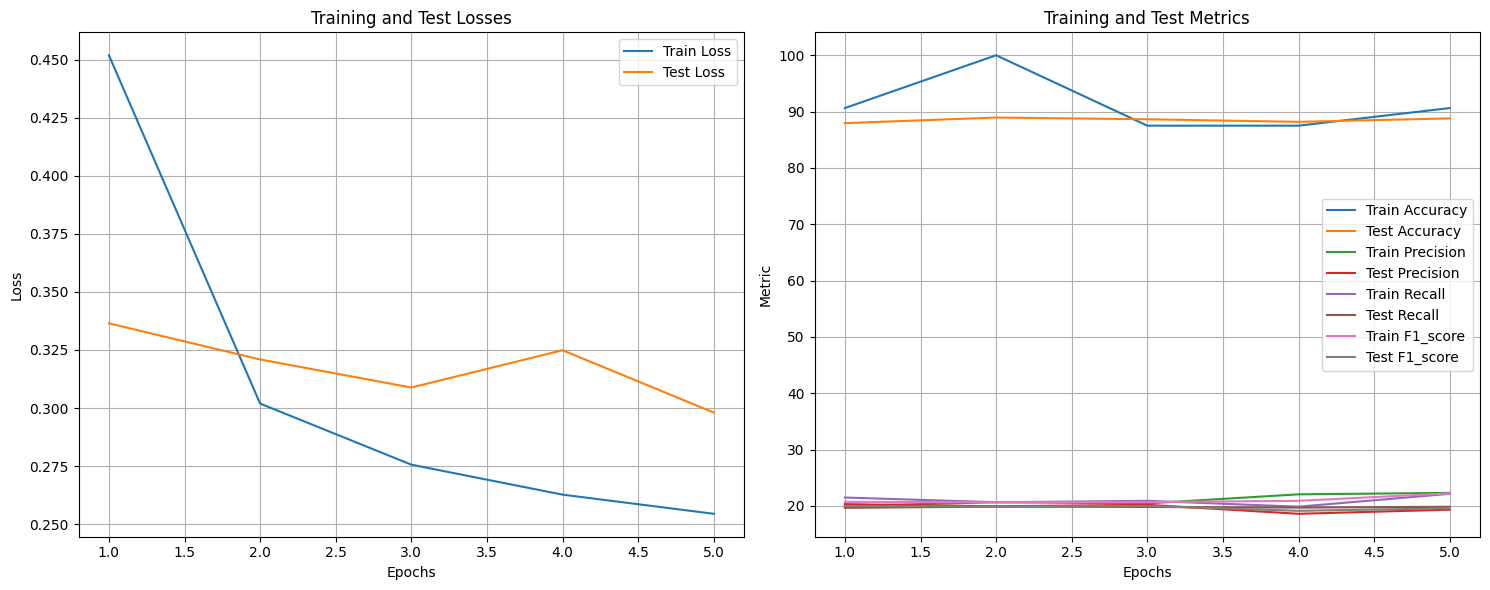

/home/gustaf/projects/deeplearning/utils/trainer.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.early_stopping.best_model_p

In [10]:
import torch
import torch.nn as nn
from torch.optim import Adadelta
import sys
from pathlib import Path

utils_dir = Path('/home/gustaf/projects/deeplearning/utils')
sys.path.append(str(utils_dir))
from metrics import precision, recall, f1_score
from trainer import ModelTrainer


# model
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)  # batch norm after first conv
        self.bn2 = nn.BatchNorm2d(16)  # batch norm after second conv

        # size calculation
        # 28x28 → conv2: 28x28 → pool: 14x14
        # 14x14 → conv2: 14x14 → pool: 7x7
        # 7x7 → flatten: 7 * 7 * 16 = 784
        flattened_size = 784

        # fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(flattened_size, output_size)  # direct output layer
        self.dropout = nn.Dropout(0.3)  # regularization

    def forward(self, x):
        # conv1 + batch norm + pooling
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        # conv2 + batch norm + pooling
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        # flatten and fully connected layer
        x = self.flatten(x)
        x = self.dropout(x)  # apply dropout
        x = self.fc(x)
        return x

# initialize model
model = SimpleNet(input_size=28*28, output_size=10)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=Adadelta(model.parameters(), lr=1, weight_decay=0.002),
    batch_size=64,
    verbose=True,
    early_stopping_patience=5,
    metrics=[ModelTrainer.accuracy]
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    test_set=testset,
    num_epochs=5
)

In [2]:
import sys
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/gustaf/projects/deeplearning/venv/lib/python3.10/site-packages',
 '/tmp/tmp6wk5mg6e']